In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
batch_size = 64
image_size = (224, 224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "training-data",
    validation_split=0.2,
    label_mode='categorical',
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "training-data",
    validation_split=0.2,
    label_mode='categorical',
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 264 files belonging to 4 classes.
Using 212 files for training.
Found 264 files belonging to 4 classes.
Using 52 files for validation.


In [23]:
train_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.float32)>

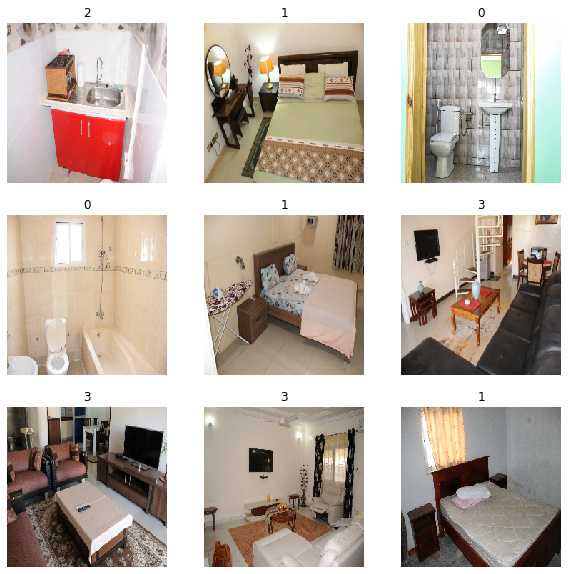

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [24]:
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, image_size), label))
val_ds = val_ds.map(lambda image, label: (tf.image.resize(image, image_size), label))

In [25]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

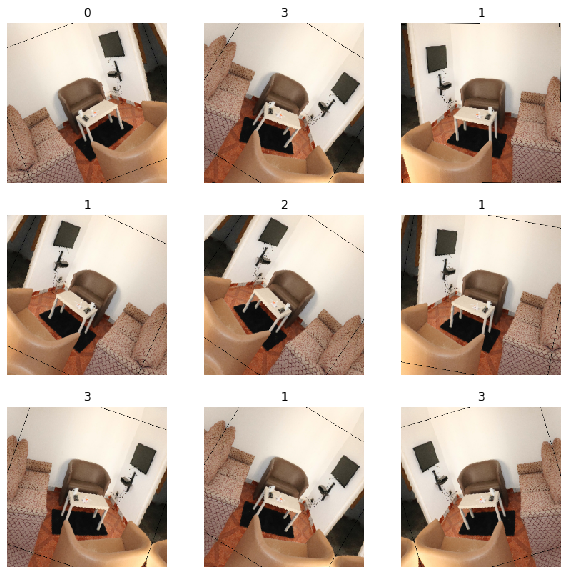

In [9]:
import numpy as np
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[1]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [26]:
IMG_HEIGHT, IMG_WIDTH = 224, 224

def create_model():
    base_model = keras.applications.MobileNet(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
        
    inputs = keras.Input(shape = (IMG_HEIGHT, IMG_WIDTH, 3))
    inputs = data_augmentation(inputs)
    norm_layer = keras.layers.experimental.preprocessing.Normalization()
    mean = np.array([127.5] * 3)
    var = mean ** 2
    # Scale inputs to [-1, +1]
    inputs = norm_layer(inputs)
    norm_layer.set_weights([mean, var])
    
    custom_model = base_model(inputs, training = False)
    custom_model = keras.layers.GlobalAveragePooling2D()(custom_model)
    custom_model = keras.layers.Dense(64, activation = 'relu')(custom_model)
    custom_model = keras.layers.Dropout(0.5)(custom_model)
    predictions = keras.layers.Dense(4, activation = 'softmax')(custom_model)
    
    return keras.Model(inputs = inputs, outputs = predictions)

In [11]:
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
# import numpy as np

# vgg_model = keras.applications.xception.Xception(weights = 'imagenet')

# img_path = 'test_img/IMG_7503.JPG'
# img = image.load_img(img_path, target_size=(299, 299))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# preds = vgg_model.predict(x)
# # decode the results into a list of tuples (class, description, probability)
# # (one such list for each sample in the batch)
# print('Predicted:', decode_predictions(preds, top=3)[0])

In [29]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

# x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(4, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_3 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

In [ ]:
# checkpoint = ModelCheckpoint("deka-view-classifier.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

epochs = 15
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/15
4/4 [==============================] - 26s 7s/step - loss: 1.3398 - accuracy: 0.3255 - val_loss: 1.0246 - val_accuracy: 0.6346
Epoch 2/15
4/4 [==============================] - 28s 7s/step - loss: 1.0048 - accuracy: 0.6462 - val_loss: 0.7274 - val_accuracy: 0.8462
Epoch 3/15
4/4 [==============================] - 25s 6s/step - loss: 0.7847 - accuracy: 0.8066 - val_loss: 0.5496 - val_accuracy: 0.8846
Epoch 4/15
